In [1]:
import os
os.chdir('..')

In [ ]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
from util import Dataset
from params import NODE_FEATURE_DIM

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:2


In [ ]:
args = {
    'processor':         'GENConv',
    'head':              'classification',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(9, 7, train_num, rng, **er_config),
        *ig.sample_instances(9, 7, train_num, rng, **ba_config),
        *ig.sample_instances(9, 7, train_num, rng, **geom_config),
    ]

test_instances = [
        *ig.sample_instances(9, 7, test_num, rng, **er_config),
        *ig.sample_instances(9, 7, test_num, rng, **ba_config),
        *ig.sample_instances(9, 7, test_num, rng, **geom_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

In [ ]:
# save(GNN, args, 'GNN3')

In [3]:
GNN, args = load('GNN1', device)

In [ ]:
from gnn_library.OBM_greedy import OBM_Greedy
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = [(threshold, OBM_Threshold_Greedy(threshold)) for threshold in thresholds]

seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

greedy_ratios = {}
for threshold, model in thresholded_greedy_models: 
    ratio = evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=eval_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
pp_output(ratios2, _, show_log=False)
print(greedy_ratios)

In [ ]:
max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(max_threshold, greedy_ratios[max_threshold])

# Pivot to feature-generated graphs

In [ ]:
# import pickle
# def get_location_info(city):
# 	intersections = ox.graph_from_place(city, network_type="drive").nodes
# 	with open(f"data/OSMNX_{city}_travel_times.pickle", "rb") as handle:
# 		drive_times = pickle.load(handle)

# 	return {
# 		'intersections': intersections, 
# 		'drive_times': drive_times,
# 		'city': city
# 	}

In [ ]:
# locations = [
#     "Piedmont, California, USA",
#     "Carmel, Indiana, USA",
#     "Geneva, Switzerland",
#     "Founex, Switzerland"
# ]

# for location in locations:
    

In [ ]:
# piedmont = get_location_info("Piedmont, California, USA")
# founex = get_location_info("Founex, Switzerland")
# carmel = get_location_info("Carmel, Indiana, USA")
# geneva = get_location_info("Geneva, Switzerland")

In [6]:
#TODO PUT BACK TO REGRESSION
#!!!!!!!!!!!!!!!!!!!!!!!!!!!
args = {
    'processor':         'TEST2',
    'head':              'regression',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  NODE_FEATURE_DIM,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 0.75,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
osmnx_config = {
    'graph_type': 'OSMNX',
    'location': "Piedmont, California, USA"
}
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(10, 6, train_num, rng, **er_config),
        *ig.sample_instances(10, 6, train_num, rng, **ba_config),
        *ig.sample_instances(10, 6, train_num, rng, **feat_config),
        *ig.sample_instances(10, 6, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(10, 6, test_num, rng, **er_config),
        *ig.sample_instances(10, 6, test_num, rng, **ba_config),
        *ig.sample_instances(10, 6, train_num, rng, **feat_config),
        *ig.sample_instances(10, 6, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [7]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/50 [00:00<?, ?Epochs/s]

TRAINING LOSS: 0.10309388669926876


Training:   2%|▏         | 1/50 [00:05<04:35,  5.63s/Epochs]

TEST LOSS: 0.06592486053705215
TEST ACCURACY: 0.6056860089302063


Training:   4%|▍         | 2/50 [00:09<03:43,  4.66s/Epochs]

TRAINING LOSS: 0.05057746350008485


Training:   6%|▌         | 3/50 [00:13<03:27,  4.42s/Epochs]

TRAINING LOSS: 0.028487674736148657


Training:   8%|▊         | 4/50 [00:17<03:18,  4.32s/Epochs]

TRAINING LOSS: 0.022587386800826174
TRAINING LOSS: 0.020149952173511246


Training:  10%|█         | 5/50 [00:23<03:35,  4.79s/Epochs]

TEST LOSS: 0.013196410611271858
TEST ACCURACY: 0.8479604125022888


Training:  12%|█▏        | 6/50 [00:26<03:08,  4.29s/Epochs]

TRAINING LOSS: 0.018624515199645676


Training:  14%|█▍        | 7/50 [00:30<02:56,  4.11s/Epochs]

TRAINING LOSS: 0.016540161931443517


Training:  16%|█▌        | 8/50 [00:34<02:45,  3.94s/Epochs]

TRAINING LOSS: 0.01726100658351045
TRAINING LOSS: 0.014564656223364513


Training:  18%|█▊        | 9/50 [00:39<02:54,  4.27s/Epochs]

TEST LOSS: 0.010151214897632599
TEST ACCURACY: 0.8510506749153137


Training:  20%|██        | 10/50 [00:42<02:38,  3.96s/Epochs]

TRAINING LOSS: 0.017506889961353873


Training:  22%|██▏       | 11/50 [00:45<02:23,  3.68s/Epochs]

TRAINING LOSS: 0.015294806846738129


Training:  24%|██▍       | 12/50 [00:48<02:13,  3.53s/Epochs]

TRAINING LOSS: 0.013499853775723155
TRAINING LOSS: 0.013053861256101801


Training:  26%|██▌       | 13/50 [00:53<02:25,  3.95s/Epochs]

TEST LOSS: 0.009761665016412735
TEST ACCURACY: 0.8590852618217468


Training:  28%|██▊       | 14/50 [00:56<02:14,  3.75s/Epochs]

TRAINING LOSS: 0.013840268267968237


Training:  30%|███       | 15/50 [01:00<02:05,  3.57s/Epochs]

TRAINING LOSS: 0.01263889324064683


Training:  32%|███▏      | 16/50 [01:03<02:00,  3.54s/Epochs]

TRAINING LOSS: 0.012919600605074374
TRAINING LOSS: 0.013433635540868561


Training:  34%|███▍      | 17/50 [01:08<02:13,  4.03s/Epochs]

TEST LOSS: 0.008530928753316402
TEST ACCURACY: 0.8479604125022888


Training:  36%|███▌      | 18/50 [01:12<02:08,  4.01s/Epochs]

TRAINING LOSS: 0.01333756443138128


Training:  38%|███▊      | 19/50 [01:16<02:01,  3.92s/Epochs]

TRAINING LOSS: 0.012366460712767076


Training:  40%|████      | 20/50 [01:20<01:55,  3.86s/Epochs]

TRAINING LOSS: 0.015821599272163926
TRAINING LOSS: 0.011518976221290918


Training:  42%|████▏     | 21/50 [01:24<02:01,  4.19s/Epochs]

TEST LOSS: 0.008038012310862541
TEST ACCURACY: 0.8584672212600708


Training:  44%|████▍     | 22/50 [01:28<01:50,  3.94s/Epochs]

TRAINING LOSS: 0.012282203768169239


Training:  46%|████▌     | 23/50 [01:32<01:44,  3.86s/Epochs]

TRAINING LOSS: 0.011703023081888806


Training:  48%|████▊     | 24/50 [01:36<01:44,  4.02s/Epochs]

TRAINING LOSS: 0.012514807249797068
TRAINING LOSS: 0.012572379937204876


Training:  50%|█████     | 25/50 [01:41<01:49,  4.36s/Epochs]

TEST LOSS: 0.00881124660372734
TEST ACCURACY: 0.8491965532302856


Training:  52%|█████▏    | 26/50 [01:45<01:40,  4.20s/Epochs]

TRAINING LOSS: 0.011271505709111557


Training:  54%|█████▍    | 27/50 [01:48<01:30,  3.94s/Epochs]

TRAINING LOSS: 0.012723899165431317


Training:  56%|█████▌    | 28/50 [01:52<01:23,  3.80s/Epochs]

TRAINING LOSS: 0.013258754364420021
TRAINING LOSS: 0.012035265648382826


Training:  58%|█████▊    | 29/50 [01:57<01:30,  4.30s/Epochs]

TEST LOSS: 0.007906962186098099
TEST ACCURACY: 0.8584672212600708


Training:  60%|██████    | 30/50 [02:00<01:19,  3.96s/Epochs]

TRAINING LOSS: 0.012458163497884653


Training:  62%|██████▏   | 31/50 [02:03<01:10,  3.70s/Epochs]

TRAINING LOSS: 0.011459998305834123


Training:  64%|██████▍   | 32/50 [02:08<01:09,  3.86s/Epochs]

TRAINING LOSS: 0.012240188560066739
TRAINING LOSS: 0.011590002693063381


Training:  66%|██████▌   | 33/50 [02:14<01:16,  4.52s/Epochs]

TEST LOSS: 0.008894450962543488
TEST ACCURACY: 0.8578491806983948


Training:  68%|██████▊   | 34/50 [02:18<01:10,  4.42s/Epochs]

TRAINING LOSS: 0.010805388654514735


Training:  70%|███████   | 35/50 [02:22<01:03,  4.27s/Epochs]

TRAINING LOSS: 0.011851995351534445


Training:  72%|███████▏  | 36/50 [02:26<00:58,  4.21s/Epochs]

TRAINING LOSS: 0.01274316786990805
TRAINING LOSS: 0.012365074641863476


Training:  74%|███████▍  | 37/50 [02:31<00:58,  4.52s/Epochs]

TEST LOSS: 0.007925642654299736
TEST ACCURACY: 0.8609394431114197


Training:  76%|███████▌  | 38/50 [02:35<00:53,  4.43s/Epochs]

TRAINING LOSS: 0.011915808222225302


Training:  78%|███████▊  | 39/50 [02:38<00:44,  4.02s/Epochs]

TRAINING LOSS: 0.010791536843469554


Training:  80%|████████  | 40/50 [02:42<00:38,  3.86s/Epochs]

TRAINING LOSS: 0.011828932269873506
TRAINING LOSS: 0.011307783016574703


Training:  82%|████████▏ | 41/50 [02:48<00:40,  4.45s/Epochs]

TEST LOSS: 0.008945396170020103
TEST ACCURACY: 0.8541408777236938


Training:  84%|████████▍ | 42/50 [02:51<00:33,  4.17s/Epochs]

TRAINING LOSS: 0.013098477225269373


Training:  86%|████████▌ | 43/50 [02:55<00:28,  4.14s/Epochs]

TRAINING LOSS: 0.010588338669553632


Training:  88%|████████▊ | 44/50 [02:59<00:24,  4.14s/Epochs]

TRAINING LOSS: 0.011013732189514283
TRAINING LOSS: 0.011615366281286338


Training:  90%|█████████ | 45/50 [03:05<00:22,  4.46s/Epochs]

TEST LOSS: 0.007850009948015213
TEST ACCURACY: 0.8597033023834229


Training:  92%|█████████▏| 46/50 [03:09<00:17,  4.41s/Epochs]

TRAINING LOSS: 0.01039976666488805


Training:  94%|█████████▍| 47/50 [03:13<00:12,  4.18s/Epochs]

TRAINING LOSS: 0.012764011920082695


Training:  96%|█████████▌| 48/50 [03:16<00:07,  3.88s/Epochs]

TRAINING LOSS: 0.011924972574075626
TRAINING LOSS: 0.010807163371406133


Training:  98%|█████████▊| 49/50 [03:20<00:04,  4.11s/Epochs]

TEST LOSS: 0.00746019696816802
TEST ACCURACY: 0.8578491806983948


Training: 100%|██████████| 50/50 [03:24<00:00,  4.08s/Epochs]

TRAINING LOSS: 0.010368226084209939


## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [ ]:
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy
from tqdm import tqdm
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
thresholds = np.linspace(0, 1, 2) # TODO remove
#TODO max value in threshold should be max value observable in graphs (is not the case for osmnx graphs for the moment)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

osmnx_config1 = {
    'graph_type': 'OSMNX',
    'location': piedmont['location_graph']
}
osmnx_config2 = {
    'graph_type': 'OSMNX',
    'location_graph': geneva['location_graph']
}
osmnx_config3 = {
    'graph_type': 'OSMNX',
    'location_graph': carmel['location_graph']
}

train_num = 10
train_instances = [
        *ig.sample_instances(9, 7, train_num, rng, **osmnx_config1),
        *ig.sample_instances(9, 7, train_num, rng, **osmnx_config2),
        *ig.sample_instances(9, 7, train_num, rng, **osmnx_config3),
]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

In [ ]:
print(greedy_ratios)

## Evaluation

In [18]:
seed = np.random.randint(0, 500000)
(m, n) = (48, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

osmnx_config = {
    'graph_type': 'OSMNX',
    'location': "Piedmont, California, USA",
    'noise': 1
}

gm_config = {
    'graph_type': 'GM',
    'noise': 0
}

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 50
eval_instances = [
        # *ig.sample_instances(m, n, eval_num, rng, **er_config),
        # *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        # *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        # *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
        *ig.sample_instances(m, n, eval_num, rng, **gm_config),
]

ratios, _ = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=5,
    baselines=['greedy', 'lp_rounding']
)


# ratios2 = ev.evaluate_model(
#     meta_model=None,
#     meta_model_type=None,
#     base_models=[THRESHOLD_MODEL],
#     instances=eval_instances,
#     batch_size=50,
#     rng=rng,
#     num_realizations=5
# )

pp_output(ratios)
#print(f"Thresholded greedy: {np.mean(ratios2[0]).round(4)}")


-- Competitive ratios --
learned: 0.925
greedy: 0.8465
lp_rounding: 0.9064


In [ ]:
num_trials = 10
node_configs = [(x, 16) for x in np.arange(4, 40, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    # {
    #     'graph_type': 'ER',
    #     'p': 0.75,
    #     'weighted': False
    # },
    # {
    #     'graph_type': 'BA',
    #     'ba_param': 4,
    #     'weighted': False
    # },
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.9,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.95,
    #     'weighted': True
    # },

    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config['location_info']['city'], node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [24]:
num_trials = 250
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 



graph_configs = [
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.5
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location': "Piedmont, California, USA"
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location': "Carmel, Indiana, USA"
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location': "Geneva, Switzerland"
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location': "Founex, Switzerland"
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.75,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.9,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.95,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.99
    # }
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
    {
        'graph_type': 'GM',
        'noise': 0
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config['graph_type'])
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )
        thresholded_greedy_ratios = [0]

        # thresholded_greedy_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
        #     meta_model=None,
        #     meta_model_type=None,
        #     base_models=[THRESHOLD_MODEL],
        #     instances=instances,
        #     batch_size=batch_size,
        #     rng=rng,
        #     num_realizations=5
        # )

        data[graph_config['graph_type']].append(np.array(
            [
                ratios["learned"],
                #thresholded_greedy_ratios,
                ratios["greedy"],
                ratios["lp_rounding"]
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
(4, 16) GM


/home/wikum/GNN-OBM/evaluate.py:366: RuntimeWarning: Mean of empty slice
  name: np.nanmean(ratio_matrix, axis=1)


(8, 16) GM
(12, 16) GM
(16, 16) GM
(20, 16) GM
(24, 16) GM
(28, 16) GM
(32, 16) GM
(36, 16) GM
(40, 16) GM
(44, 16) GM
(48, 16) GM
(52, 16) GM
(56, 16) GM
(60, 16) GM


/home/wikum/GNN-OBM/algorithms.py:258: RuntimeWarning: invalid value encountered in divide
  proposal_probs = x / denom_matrix


In [38]:
data['GM'][0][0, :].shape

(250,)

In [40]:
def _plot_ratios(ratios, data, naming_function = lambda graph_type: graph_type, confidence = 0.99):
    import scipy.stats as st
    import matplotlib.pyplot as plt

    models =  ["GNN", "greedy", "lp_approx"]
    for graph_type, ratios_by_regime in data.items():
        aggregated_ratios = {model: [] for model in models}

        for regime_ratios in ratios_by_regime:
            for i, model in enumerate(models):
                raw_values = regime_ratios[i, :]
                raw_mean = np.mean(raw_values)
                ci_lowerbound, ci_upperbound = st.norm.interval(
                    alpha=confidence, 
                    loc=raw_mean, 
                    scale=st.sem(raw_values)
                )
                aggregated_ratios[model].append((raw_mean, ci_lowerbound, ci_upperbound))


        fig = plt.figure(figsize=(8,6))
        for model, model_ratios in aggregated_ratios.items():
            competitive_ratios = [val[0] for val in model_ratios]
            ci_lowerbounds = [val[1] for val in model_ratios]
            ci_upperbounds = [val[2] for val in model_ratios]
            plt.plot(ratios, competitive_ratios, label=model)
            plt.fill_between(ratios, ci_lowerbounds, ci_upperbounds, alpha = 0.2)

        title = f"{naming_function(graph_type)}"
        plt.title(title, fontsize = 18)
        plt.xlabel('# online / # offline', fontsize = 15)
        plt.ylabel('Average competitive ratio', fontsize = 15)
        plt.legend()
        plt.savefig(f"data/{title.replace(' ', '_')}.png")
        plt.show()


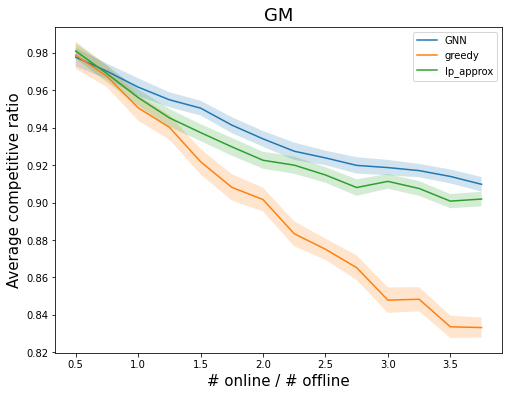

In [41]:
_plot_ratios(ratios, data, lambda x: "GM", confidence=0.95)

In [ ]:
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        for models in ["learned", "greedy", "lp_rounding"]:
            data[graph_config['graph_type']][]

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]


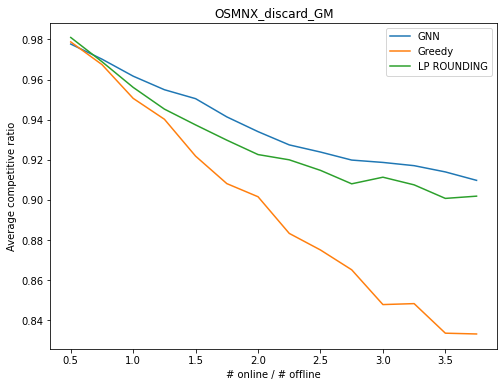

In [25]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
print(ratios)
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        #thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())
        

    title = f"OSMNX_discard_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    #plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    #plt.savefig(f"data/{title}.png")
    plt.show()



In [26]:
from util import _plot_approx_ratios
_plot_approx_ratios(ratios, data, lambda graph_type: "GM", confidence=0.95)

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [33]:
len(data['GM'])

15

In [ ]:

import scipy.stats as st 

def _plot_approx_ratios(ratios, data, naming_function = lambda graph_type: graph_type, confidence = 0.99):

    for graph_type, graph_ratios in data.items():
        aggregated_ratios = {}

        for trial_ratios in comp_ratios:
            for model, ratio_values in trial_ratios.items():
                current_ratios = aggregated_ratios.get(model, [])
                
                # Compute the confidence interval for the competitive ratios
                ci_lowerbound, ci_upperbound = st.norm.interval(alpha=confidence, 
                                loc=np.mean(ratio_values), 
                                scale=st.sem(ratio_values)) 
                current_ratios.append((np.array(ratio_values).mean(), ci_lowerbound, ci_upperbound))
                aggregated_ratios[model] = current_ratios

        fig = plt.figure(figsize=(8,6))
        for model, model_ratios in aggregated_ratios.items():
            competitive_ratios = [val[0] for val in model_ratios]
            ci_lowerbounds = [val[1] for val in model_ratios]
            ci_upperbounds = [val[2] for val in model_ratios]
            plt.plot(ratios, competitive_ratios, label=model)
            plt.fill_between(ratios, ci_lowerbounds, ci_upperbounds, alpha = 0.2)

        title = f"{naming_function(graph_type)}"
        plt.title(title, fontsize = 18)
        plt.xlabel('# online / # offline', fontsize = 15)
        plt.ylabel('Average competitive ratio', fontsize = 15)
        plt.legend()
        plt.savefig(f"data/{title.replace(' ', '_')}.png")
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    # plt.savefig(f"data/{title}.png")
    plt.show()


## Graph transferability

In [25]:
num_trials = 40
node_configs = [(x, x) for x in np.arange(4, 40, 4)]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]


graph_configs = [
    {
    'graph_type': 'FEAT',
    'q': 0.75,
    'weighted': True
    },
]

sizes = [x for (x,_) in node_configs]
print(sizes)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)

        cr_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        thresholded_greedy_ratios = [0]

        data[graph_config['q']].append(cr_ratios)

[4, 8, 12, 16, 20, 24, 28, 32, 36]
(4, 4) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
Set parameter TokenServer to value "soal-nas.stanford.edu"
(8, 8) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(12, 12) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(16, 16) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(20, 20) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(24, 24) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(28, 28) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(32, 32) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(36, 36) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}


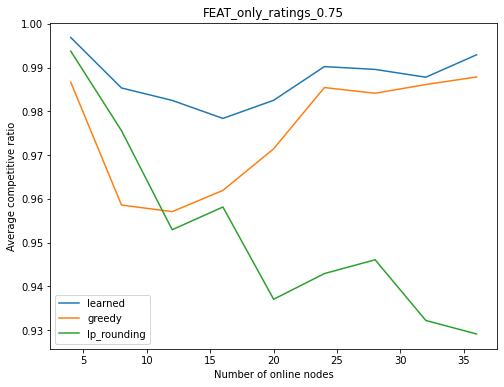

In [26]:
import matplotlib.pyplot as plt

sizes = [x for (x,_) in node_configs]

aggregated_ratios = {}
for q, comp_ratios in data.items():
    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

fig = plt.figure(figsize=(8,6))
for model, ratios in aggregated_ratios.items():
    plt.plot(sizes, ratios, label=model)

title = f"FEAT_only_ratings_{q}"
plt.title(title)
plt.xlabel('Number of online nodes')
plt.ylabel('Average competitive ratio')
plt.legend()
# plt.savefig(f"data/{title}.png")
plt.show()
